<a href="https://colab.research.google.com/github/geocarvalho/python-ds/blob/master/alura/intro_nlp_1_e_2/intro_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalhando com os dados do IMDB

* [IMDB PT-BR: Tradução do dataset IMdb para o português](https://www.kaggle.com/luisfredgs/imdb-ptbr)


In [59]:
!pip install unidecode

     |████████████████████████████████| 245kB 2.9MB/s 


In [0]:
import nltk
import unidecode
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:

nltk.download('all')
%matplotlib inline

In [2]:
path = './imdb-reviews-pt-br.csv'
resenha = pd.read_csv(path)
resenha.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


# Introdução parte 1

In [3]:
# Proporção de classes
resenha.sentiment.value_counts()

neg    24765
pos    24694
Name: sentiment, dtype: int64

In [4]:
# Binarizar as classes
mudar = {'neg': 0, 'pos': 1}
resenha.sentiment = resenha.sentiment.map(mudar)
resenha.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,0
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",0
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,0
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,0


* Criar vocabulário usando *bag of words* (sacola de palavras), um método de extração de features que cria vetores com classificação e pertence ou não a palavra;

* *Bag of words* cria uma *label* para cada palavra do nossos dados, ocupando grande parte da memória. Dentro dessa representação há linhas e colunas com valores nulos (**matriz esparsa**). Para evitar *overflow* de memória se usa `SparseDataFrame`.

```
df = pd.SparseDataFrame(matriz_esparsa)
```


In [5]:
# Exemplo de bag of words
text = ['Assisti um filme ótimo', 'Assisti um filme ruim']
vetorizar = CountVectorizer(lowercase=False)
bow = vetorizar.fit_transform(text)
bow

<2x5 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [6]:
matriz_esparsa = pd.DataFrame.sparse.from_spmatrix(bow, columns=vetorizar.get_feature_names())
#  pandas.DataFrame.sparse.from_spmatrix(bag_of_words, columns=vetorizar.get_feature_names()))
matriz_esparsa

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pyd

,Assisti,filme,ruim,um,ótimo
0,1,1,NaN,1,1.0
1,1,1,1.0,1,NaN


In [7]:
vetorizar = CountVectorizer(lowercase=False, max_features=50)
bow = vetorizar.fit_transform(resenha.text_pt)
bow.shape

(49459, 50)

In [0]:
# matriz_esparsa = pd.SparseDataFrame(bow, columns=vetorizar.get_feature_names())
# matriz_esparsa = matriz_esparsa.fillna(0)
# matriz_esparsa.head()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(bow, resenha.sentiment, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37094, 50), (12365, 50), (37094,), (12365,))

In [10]:
lr = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
acc = lr.score(X_test, y_test)
acc

0.6583097452486858

In [13]:
def classificar_texto(texto, coluna_texto, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase=False, max_features=50)
    bow = vetorizar.fit_transform(texto[coluna_texto])
    X_train, X_test, y_train, y_test = train_test_split(bow, texto[coluna_classificacao], random_state=42)
    lr = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
    acc = lr.score(X_test, y_test)
    return acc

classificar_texto(resenha, 'text_pt', 'sentiment')


0.6583097452486858

In [0]:
todas_palavras = ' '.join([texto for texto in resenha['text_pt']])
nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110,
                           collocations=False).generate(todas_palavras)


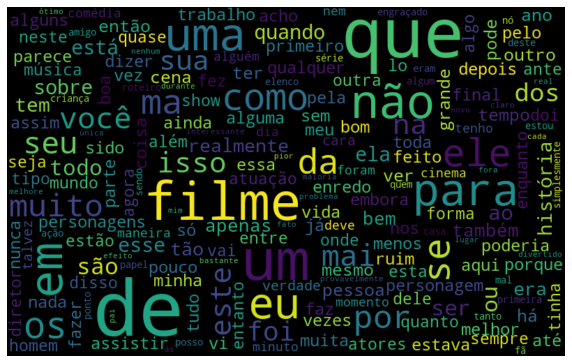

In [19]:
plt.figure(figsize=(10,7))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis('off')
plt.show()

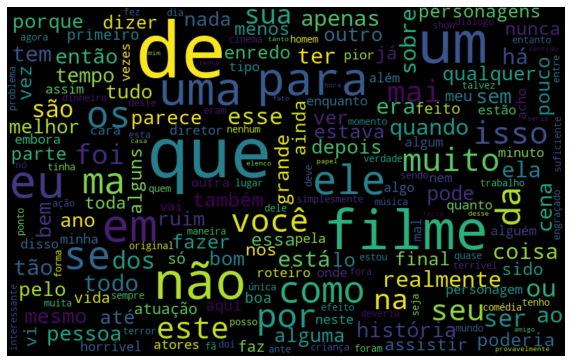

In [21]:

def nuvem_palavras(texto_filtrado, coluna_texto):
  todas_palavras = ' '.join([texto for texto in texto_filtrado[coluna_texto]])
  nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110,
                            collocations=False).generate(todas_palavras)
  plt.figure(figsize=(10,7))
  plt.imshow(nuvem_palavras, interpolation='bilinear')
  plt.axis('off')
  plt.show()

texto_negativo = resenha.query('sentiment == 0')
nuvem_palavras(texto_negativo, "text_pt")

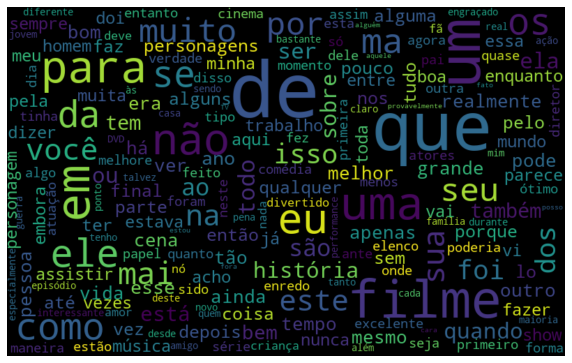

In [22]:

texto_positivo = resenha.query('sentiment == 1')
nuvem_palavras(texto_positivo, "text_pt")

In [26]:
# Exemplo com NLTK
frase = ['um filme ruim', 'um filme bom']
freq = nltk.FreqDist(frase)
freq

FreqDist({'um filme bom': 1, 'um filme ruim': 1})

In [28]:
# Tokenização
frase = 'Bem vindo ao mundo do PLN!'
token_espaco = nltk.tokenize.WhitespaceTokenizer()
token_frase = token_espaco.tokenize(frase)
token_frase


['Bem', 'vindo', 'ao', 'mundo', 'do', 'PLN!']

In [30]:
# Tokenizando os dados
token_espaco = nltk.tokenize.WhitespaceTokenizer()
token_frase = token_espaco.tokenize(todas_palavras)
freq = nltk.FreqDist(token_frase)
freq

FreqDist({'Mais': 1538,
          'uma': 130888,
          'vez,': 1927,
          'o': 244881,
          'Sr.': 1741,
          'Costner': 50,
          'arrumou': 3,
          'um': 216410,
          'filme': 117543,
          'por': 61339,
          'muito': 51761,
          'mais': 53504,
          'tempo': 10424,
          'do': 101737,
          'que': 325070,
          'necessário.': 135,
          'Além': 3631,
          'das': 16496,
          'terríveis': 576,
          'seqüências': 586,
          'de': 417651,
          'resgate': 152,
          'no': 57145,
          'mar,': 63,
          'quais': 1537,
          'há': 15824,
          'poucas,': 7,
          'eu': 68814,
          'simplesmente': 6436,
          'não': 127915,
          'me': 19136,
          'importei': 109,
          'com': 99174,
          'nenhum': 4531,
          'dos': 41222,
          'personagens.': 1027,
          'A': 31547,
          'maioria': 5565,
          'nós': 3944,
          'tem': 2498

In [34]:
df_freq = pd.DataFrame({'Palavra': list(freq.keys()), 
                        'Frequencia': list(freq.values())}).sort_values(by=['Frequencia'], ascending=False)
df_freq.head(10)

,Palavra,Frequencia
20,de,417651
14,que,325070
42,e,299743
3,o,244881
7,um,216410
102,a,210179
45,é,192381
200,em,132778
1,uma,130888
29,não,127915


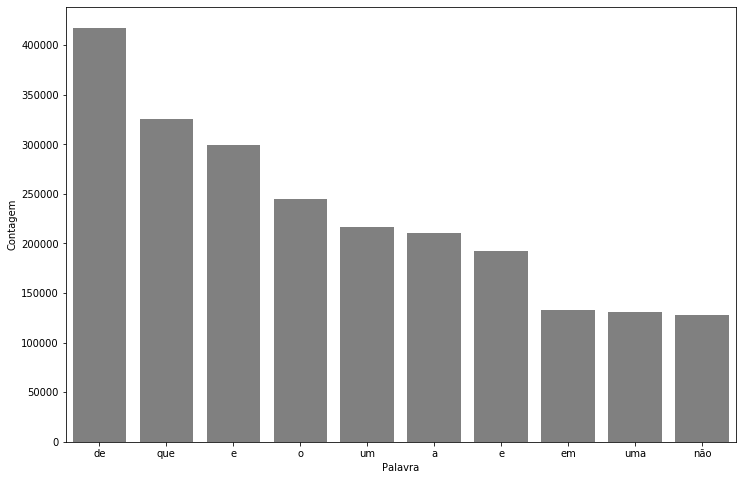

In [38]:
# Grafico de pareto

plt.figure(figsize=(12,8))
ax = sns.barplot(data=df_freq.head(10), x='Palavra', y='Frequencia', color='gray')
ax.set(ylabel='Contagem')
plt.show()

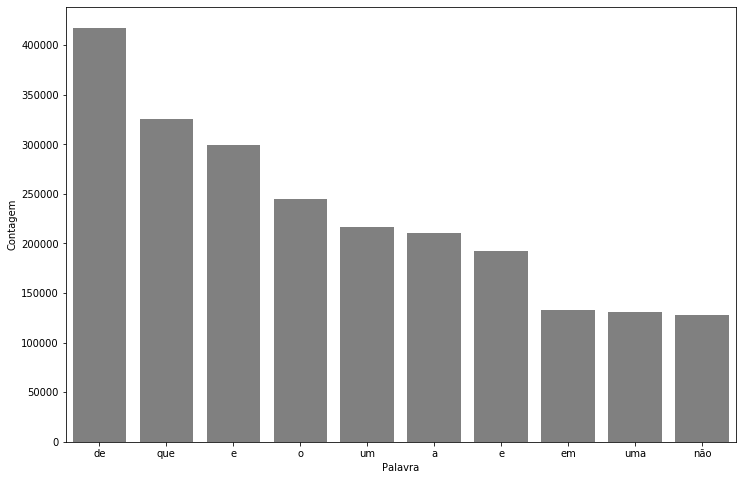

In [39]:
def pareto(texto, coluna_texto, quantidade):
  todas_palavras = ' '.join([texto for texto in texto[coluna_texto]])
  token_espaco = nltk.tokenize.WhitespaceTokenizer()
  token_frase = token_espaco.tokenize(todas_palavras)
  freq = nltk.FreqDist(token_frase)
  df_freq = pd.DataFrame({
      'Palavra': list(freq.keys()),
      'Frequencia': list(freq.values())}).sort_values(
          by=['Frequencia'], ascending=False)

  plt.figure(figsize=(12,8))
  ax = sns.barplot(data=df_freq.head(quantidade), x='Palavra', y='Frequencia', color='gray')
  ax.set(ylabel='Contagem')
  plt.show()

pareto(resenha, 'text_pt', 10)

In [47]:
# Removendo stopwords em pt-br
palavras_irrelevantes = nltk.corpus.stopwords.words('portuguese')

def remove_words(df, lst_palavras=palavras_irrelevantes):
  token_espaco = nltk.tokenize.WhitespaceTokenizer()
  palavras_texto = token_espaco.tokenize(df.text_pt)
  tratamento_1 = ' '.join([palavra for palavra in palavras_texto if palavra not in lst_palavras])
  return tratamento_1

resenha['tratamento_1'] = resenha.apply(lambda x: remove_words(x, palavras_irrelevantes), axis=1)
resenha.head()

,id,text_en,text_pt,sentiment,tratamento_1
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",0,"Mais vez, Sr. Costner arrumou filme tempo nece..."
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,0,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",0,"Primeiro tudo odeio raps imbecis, poderiam agi..."
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,0,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,0,"Filmes fotos latão palavra apropriada eles, ve..."


In [48]:
classificar_texto(resenha, 'tratamento_1', 'sentiment')

0.6607359482410028

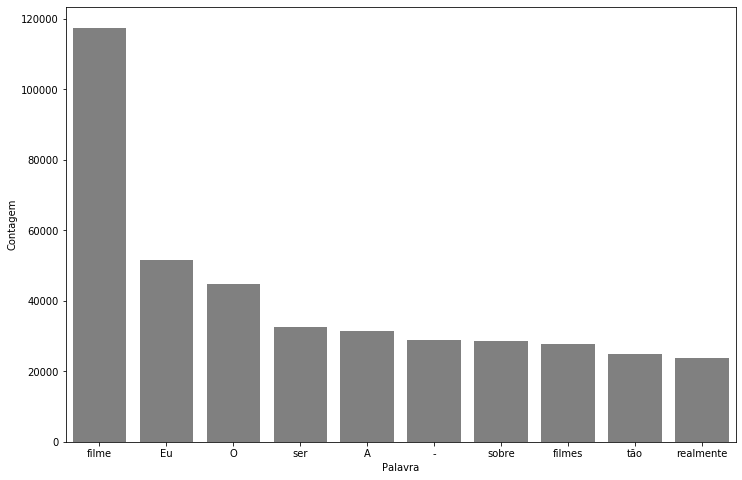

In [49]:
pareto(resenha, 'tratamento_1', 10)

# Introdução NLP parte 2

In [50]:
# Tokenização limpando pontuação

frase = 'Olá mundo!'
token_pontuacao = nltk.tokenize.WordPunctTokenizer()
token_frase = token_pontuacao.tokenize(frase)
token_frase

['Olá', 'mundo', '!']

In [55]:
# Removendo stopwords em pt-br e pontuações
pontuacao = [ponto for ponto in punctuation]
palavras_irrelevantes = nltk.corpus.stopwords.words('portuguese')
pontuacao_stopwords = pontuacao + palavras_irrelevantes

def remove_words(df, lst_palavras=pontuacao_stopwords):
  token_espaco = nltk.tokenize.WordPunctTokenizer()
  palavras_texto = token_espaco.tokenize(df.tratamento_1)
  tratamento_2 = ' '.join([palavra for palavra in palavras_texto if palavra not in lst_palavras])
  return tratamento_2

resenha['tratamento_2'] = resenha.apply(lambda x: remove_words(x, pontuacao_stopwords), axis=1)
resenha.head()

,id,text_en,text_pt,sentiment,tratamento_1,tratamento_2
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",0,"Mais vez, Sr. Costner arrumou filme tempo nece...",Mais vez Sr Costner arrumou filme tempo necess...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,0,Este exemplo motivo maioria filmes ação mesmos...,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",0,"Primeiro tudo odeio raps imbecis, poderiam agi...",Primeiro tudo odeio raps imbecis poderiam agir...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,0,Nem Beatles puderam escrever músicas todos gos...,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,0,"Filmes fotos latão palavra apropriada eles, ve...",Filmes fotos latão palavra apropriada verdade ...


In [56]:
resenha['tratamento_2'][0]

'Mais vez Sr Costner arrumou filme tempo necessário Além terríveis seqüências resgate mar quais poucas simplesmente importei nenhum personagens A maioria fantasmas armário personagem Costers realizado logo início esquecido tarde importava O personagem deveríamos importar arrogante superconfiante Ashton Kutcher O problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armário desordenado Seu único obstáculo parece estar vencendo Costner Finalmente bem além meio caminho Costner conta sobre fantasmas Kutchers Somos informados Kutcher levado ser melhor pressentimentos presságios anteriores Nenhuma mágica aqui tudo podia fazer desligar hora'

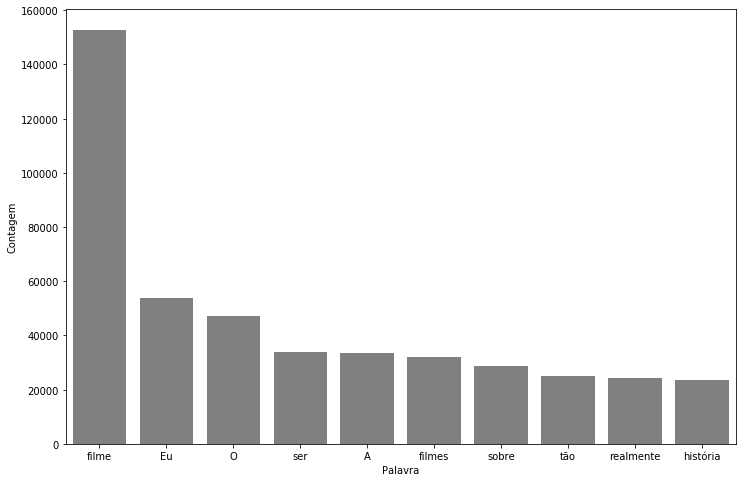

In [57]:
pareto(resenha, 'tratamento_2', 10)

In [61]:
# Removendo acentos
acentos = 'ótimo, péssimo não é tão'
teste = unidecode.unidecode(acentos)
teste

'otimo, pessimo nao e tao'

In [88]:
# Removendo stopwords em pt-br, pontuações e acentos
pontuacao = [ponto for ponto in punctuation]
palavras_irrelevantes = nltk.corpus.stopwords.words('portuguese')
palavras_irrelevantes = [unidecode.unidecode(palavra.lower()) for palavra in palavras_irrelevantes]
pontuacao_stopwords = pontuacao + palavras_irrelevantes

def remove_words(df, lst_palavras=pontuacao_stopwords):
  token_espaco = nltk.tokenize.WordPunctTokenizer()
  palavras_texto = token_espaco.tokenize(df.tratamento_2)
  tratamento_3 = ' '.join([unidecode.unidecode(palavra.lower()) for palavra in palavras_texto if unidecode.unidecode(palavra.lower()) not in lst_palavras])
  return tratamento_3

resenha['tratamento_3'] = resenha.apply(lambda x: remove_words(x, pontuacao_stopwords), axis=1)
resenha.head()

,id,text_en,text_pt,sentiment,tratamento_1,tratamento_2,tratamento_3
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",0,"Mais vez, Sr. Costner arrumou filme tempo nece...",Mais vez Sr Costner arrumou filme tempo necess...,vez sr costner arrumou filme tempo necessario ...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,0,Este exemplo motivo maioria filmes ação mesmos...,Este exemplo motivo maioria filmes ação mesmos...,exemplo motivo maioria filmes acao mesmos gene...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",0,"Primeiro tudo odeio raps imbecis, poderiam agi...",Primeiro tudo odeio raps imbecis poderiam agir...,primeiro tudo odeio raps imbecis poderiam agir...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,0,Nem Beatles puderam escrever músicas todos gos...,Nem Beatles puderam escrever músicas todos gos...,beatles puderam escrever musicas todos gostass...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,0,"Filmes fotos latão palavra apropriada eles, ve...",Filmes fotos latão palavra apropriada verdade ...,filmes fotos latao palavra apropriada verdade ...


In [89]:
resenha['tratamento_3'][4]

'filmes fotos latao palavra apropriada verdade tanto ousados qualidades visuais atraentes reminiscentes comerciais tv caros alta classe infelizmente imagens brass longas metragens pretexto querer entreter telespectadores durante duas horas nisto falham miseravelmente qualidades eroticas inegaveis bastante suaves flacidas vaporosas resistentes senso 45 remake filme luchino visconti titulo alida valli farley granger lideranca original conta historia amor sentido luxuria veneza arredores durante guerras italianas independencia brass moveu acao seculo 19 seculo 20 1945 ser exato entao murais mussolini homens camisa preta uniformes alemaes traje esfarrapado partidarios apenas fachada contexto historico completamente insignificante anna galiena interpreta atraente mulher aristocratica apaixona cara amoral ss sempre usa batom atriz italiana atraente versatil bem treinada claramente acima material ampla gama expressoes faciais sinalizando tedio aversao prazer medo odio ... extase melhor razao 

In [90]:
classificar_texto(resenha, 'tratamento_3', 'sentiment')

0.6879094217549535

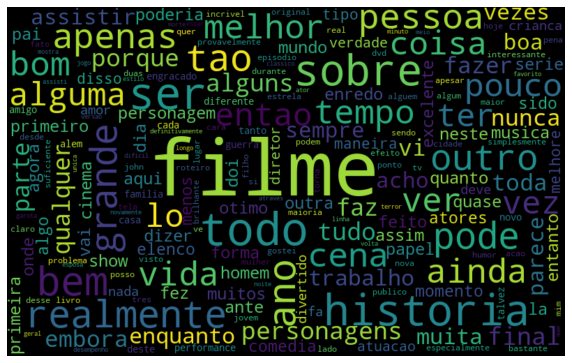

In [91]:
texto_positivo = resenha.query('sentiment == 1')
nuvem_palavras(texto_positivo, "tratamento_3")

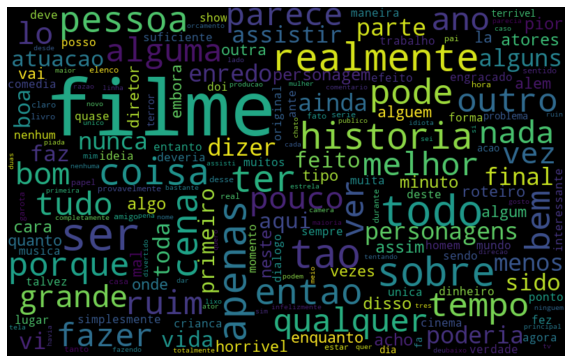

In [95]:
texto_negativo = resenha.query('sentiment == 0')
nuvem_palavras(texto_negativo, "tratamento_3")

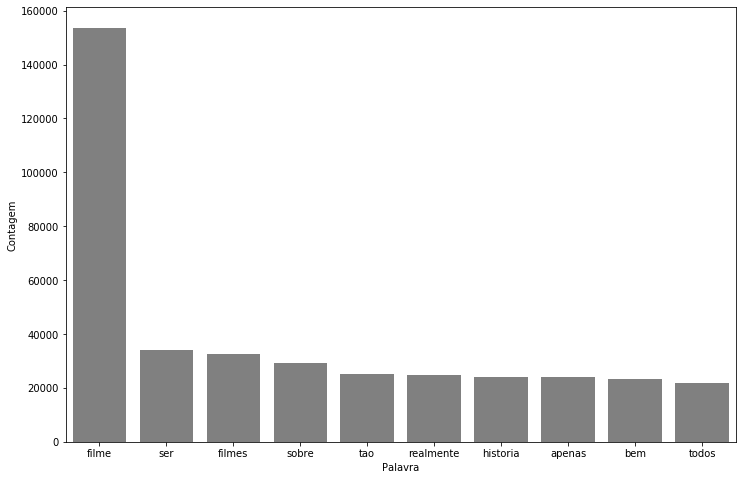

In [93]:
pareto(resenha, 'tratamento_3', 10)

In [96]:
# Reduzindo para radicais comuns, stemização

stemmer = nltk.RSLPStemmer()
print(stemmer.stem('corredor'))
print(stemmer.stem('corre'))
print(stemmer.stem('correria'))

corr
corr
corr


In [97]:
# Removendo stopwords em pt-br, pontuações, acentos e aplicar stemmer
pontuacao = [ponto for ponto in punctuation]
palavras_irrelevantes = nltk.corpus.stopwords.words('portuguese')
palavras_irrelevantes = [unidecode.unidecode(palavra.lower()) for palavra in palavras_irrelevantes]
pontuacao_stopwords = pontuacao + palavras_irrelevantes

def remove_words(df, lst_palavras=pontuacao_stopwords):
  token_espaco = nltk.tokenize.WordPunctTokenizer()
  palavras_texto = token_espaco.tokenize(df.tratamento_3)
  lst_frase = [unidecode.unidecode(palavra.lower()) for palavra in palavras_texto if unidecode.unidecode(palavra.lower()) not in lst_palavras]
  tratamento_4 = ' '.join([stemmer.stem(palavra) for palavra in lst_frase])
  return tratamento_4

resenha['tratamento_4'] = resenha.apply(lambda x: remove_words(x, pontuacao_stopwords), axis=1)
resenha.head()

,id,text_en,text_pt,sentiment,tratamento_1,tratamento_2,tratamento_3,tratamento_4
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",0,"Mais vez, Sr. Costner arrumou filme tempo nece...",Mais vez Sr Costner arrumou filme tempo necess...,vez sr costner arrumou filme tempo necessario ...,vez sr costn arrum film temp necessari alem te...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,0,Este exemplo motivo maioria filmes ação mesmos...,Este exemplo motivo maioria filmes ação mesmos...,exemplo motivo maioria filmes acao mesmos gene...,exempl motiv maior film aca mesm gener chat na...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",0,"Primeiro tudo odeio raps imbecis, poderiam agi...",Primeiro tudo odeio raps imbecis poderiam agir...,primeiro tudo odeio raps imbecis poderiam agir...,prim tud odei rap imbecil pod agir arm pressio...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,0,Nem Beatles puderam escrever músicas todos gos...,Nem Beatles puderam escrever músicas todos gos...,beatles puderam escrever musicas todos gostass...,beatl pud escrev music tod gost emb walt hill ...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,0,"Filmes fotos latão palavra apropriada eles, ve...",Filmes fotos latão palavra apropriada verdade ...,filmes fotos latao palavra apropriada verdade ...,film fot lata palavr apropri verdad tant ous q...


In [98]:
resenha['tratamento_4'][4]

'film fot lata palavr apropri verdad tant ous qual visual atra reminisc comerc tv car alt cl infeliz imag bras long metr pretext quer entret telespect dur dua hor nist falh misera qual ero inega bast suav flac vapor resist sens 45 remak film luchin viscont titul alid vall farley grang lideranc orig cont hist am sent luxur ven arr dur guerr itali independenc bras mov aca secul 19 secul 20 1945 ser exat enta mural mussolin hom camis pret uniform alema traj esfarrap partidari apen fach context histor complet insignific ann galien interpret atra mulh aristocra apaix car amor ss sempr usa batom atriz itali atra versatil bem trein cl acim mater ampl gam expresso fac sinaliz tedi aversa praz med odi ... extas melhor raza assist fot val dua estrel suport mater basic inutil quant impression dign desej algum part real boa aparec real merec'

In [99]:
classificar_texto(resenha, 'tratamento_4', 'sentiment')

0.6943792964011323

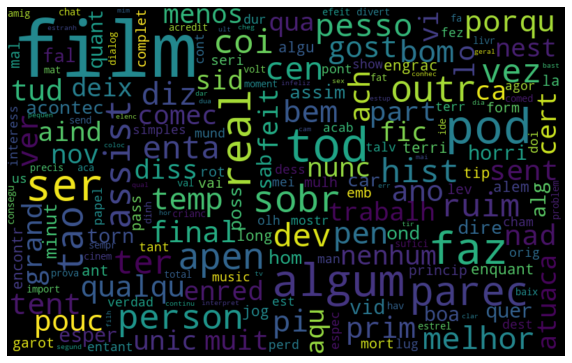

In [100]:
texto_negativo = resenha.query('sentiment == 0')
nuvem_palavras(texto_negativo, "tratamento_4")

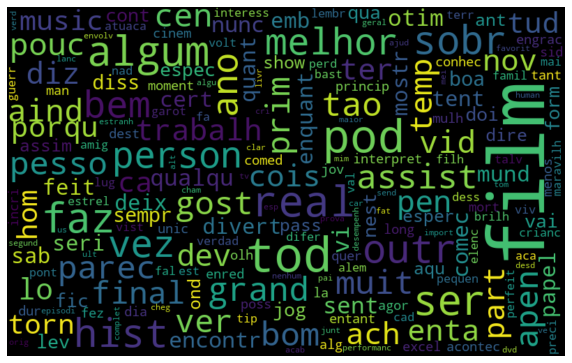

In [101]:
texto_negativo = resenha.query('sentiment == 1')
nuvem_palavras(texto_negativo, "tratamento_4")

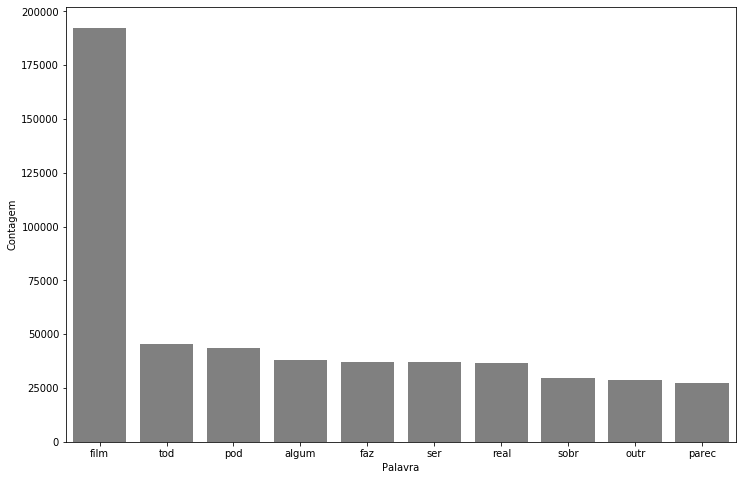

In [102]:
pareto(resenha, 'tratamento_4', 10)

In [105]:
# Testando TF-IDF

frases = ['Assistir um filme ótimo', 'Assistir um filme péssimo']
tfidf = TfidfVectorizer(lowercase=False, max_features=50)
caracteristicas = tfidf.fit_transform(frases)
pd.DataFrame(caracteristicas.todense(), columns=tfidf.get_feature_names())


,Assistir,filme,péssimo,um,ótimo
0,0.448321,0.448321,0.000000,0.448321,0.630099
1,0.448321,0.448321,0.630099,0.448321,0.000000


In [115]:
# Aplicando TF-IDF

def classificar_tfidf(texto, coluna_texto, coluna_classificacao):
    tfidf = TfidfVectorizer(lowercase=False)
    tfidf_bruto = tfidf.fit_transform(texto[coluna_texto])
    X_train, X_test, y_train, y_test = train_test_split(tfidf_bruto, texto[coluna_classificacao], random_state=42)
    lr = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
    acc = lr.score(X_test, y_test)
    return acc

classificar_tfidf(resenha, 'tratamento_4', 'sentiment')


0.8841892438334007

In [111]:
# Manter uma sequencia (memoria) no texto, usando ngrams que dobra as dimensoes mantendo um conexao entre palavras
frase = 'Assisti um ótimo filme.'
frase_separada = token_espaco.tokenize(frase)
pares = nltk.ngrams(frase_separada, 2)
list(pares)

[('Assisti', 'um'), ('um', 'ótimo'), ('ótimo', 'filme.')]

In [124]:
def classificar_tfidf(texto, coluna_texto, coluna_classificacao):
    tfidf = TfidfVectorizer(lowercase=False, ngram_range=(1,2 ))
    tfidf_bruto = tfidf.fit_transform(texto[coluna_texto])
    X_train, X_test, y_train, y_test = train_test_split(tfidf_bruto, texto[coluna_classificacao], random_state=42)
    lr = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
    acc = lr.score(X_test, y_test)
    return acc, lr, tfidf

acc, lr, tfidf = classificar_tfidf(resenha, 'tratamento_4', 'sentiment')
acc

0.8858875859280226

In [130]:
pesos = pd.DataFrame(lr.coef_[0].T, index=tfidf.get_feature_names())
# O que foi indicado como positivo?
pesos.nlargest(10,0)

,0
otim,9.883148
excel,8.998212
perfeit,6.909051
maravilh,6.277557
favorit,5.888959
incri,5.746389
divert,5.411610
brilh,4.856989
ador,4.570598
hoj,4.491365


In [131]:
# O que foi indicado como negativo?
pesos.nsmallest(10,0)

,0
ruim,-11.761766
pi,-11.424122
horri,-9.701481
terri,-8.386112
nad,-7.610627
chat,-7.508107
parec,-6.628180
nenhum,-6.369930
tent,-5.774706
mal,-5.710310
